# CYPLAN 255 Project

## Using Open-Source Bike Share Trip Data to Inform Social Distancing Street Closures

### `1_Explore_BayWheels_Trips`

This data does less processing and more exploratory analysis to visualize the Bay Wheels origin-destination trips. The charts and figures created in this notebook can be used to set the stage for further analysis and provide background information on the data.

**Datasets used:**
* [System data](https://www.lyft.com/bikes/bay-wheels/system-data) from Bay Wheels. We process only trips from February 2020 because it is the latest dataset available (most current station layout and trip flows).
* [Regional bicycle facilities](http://opendata.mtc.ca.gov/datasets/regional-bike-facilities?geometry=-122.400%2C37.800%2C-122.144%2C37.847) in the Bay Area. From the Metropolitan Transportation Commission.
* Census boundaries for California, including polygons for the state outline, census-designated places, and tracts.

**Notebook summary:**
* 1.0 - Import packages
* 1.1 - Import data
* 1.2 - Create a heatmap of trips by time of day and day of the week using Seaborn
* 1.3 - Explore the breakdown of type of bike facility in the Bay Area

## 1.0 Initialize notebook

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
sns.set()

## 1.1 Load data

In [3]:
# load raw trip data
trips = pd.read_csv("../data/202002-baywheels-tripdata.csv", low_memory=False)

In [4]:
# load bicycle facilities in Bay Area
facilities = gpd.read_file("../data/regional_bike_facilities.geojson")

# class / class_type :
# 1 = 'Off-Street Shared-Use Path'
# 2 = 'Bike Lane'
# 3 = 'On-Street Bike Route'

In [16]:
# load bounding boxes for station regions
bbox_gdf = gpd.read_file("../data/baywheels_regions_bbox.geojson")

## 1.2 Heatmap

When do people use Bay Wheels? Are trips taken for leisure or for a purpose? Seaborn has a heatmap visualization that can plot a month of Bay Wheel trips by day of the week and time of day.

Sources referenced for this section:
* http://seaborn.pydata.org/examples/heatmap_annotation.html
* https://seaborn.pydata.org/generated/seaborn.heatmap.html

Additional sources that could be used to create time series animations of these heatmaps:
* Code for [creating animations](https://stackoverflow.com/questions/46236902/redrawing-seaborn-figures-for-animations) in matplotlib
* Simpler [animation](https://python-graph-gallery.com/340-scatterplot-animation/) in seaborn using gifs

In [5]:
# truncate data to be list of trip counts by day of week (0-6) and hour of day (0-23)
trips['start_time'] = pd.to_datetime(trips.start_time, format='%Y-%m-%d %H:%M:%S.%f')
trips['day'] = trips['start_time'].dt.weekday
trips['hour'] = trips['start_time'].dt.hour
heatmap_df = trips.groupby(['day', 'hour']).start_time.count().reset_index()
heatmap_df.rename(columns={"start_time": "count"}, inplace=True)

In [6]:
# convert to long-form and rename index
heatmap_df = heatmap_df.pivot("day", "hour", "count")
heatmap_df.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
heatmap_df.index.name = 'day'

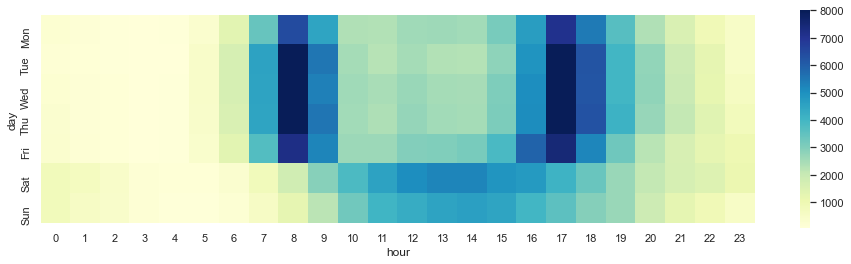

In [7]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(16, 4))
sns.heatmap(heatmap_df, 
            cmap="YlGnBu", 
            square=True, 
            vmax=8000,
            ax=ax)

There are distinct trip patterns. During weekdays people are most frequently using Bay Wheels for travel between 8am-9am and 5pm-6pm, which lines up with peak period travel for work. There are trips made during weekdays outside of these times but not to the same magnitude.

On the weekend the morning/evening work trip peaks disappear. Instead people are using Bay Wheels bikes for trips during the middle of the day. These are likely leisure or errand trips for people moving around on the weekend. They do not occur with the same magnitude as weekday peak period trips. When exploring trip routes it may make sense to split up weekday and weekend travel because trip patterns may differ with trip purpose.

Bay Wheels is not often used in the evening, possibly because people do not feel safe biking at night.

## 1.3 Bike facility breakdown by type

What kind of bike facilities are there in the Bay? How many lane-miles are there of each type? How many lane-miles are in each Bay Wheels region?

In [30]:
# Convert the gdf to NAD83 (a projected coordinate system) so we can get length
# measurements in meters.
facilities = facilities.to_crs('epsg:3310')

# Create a new column with the length of each facility (meters and miles)
facilities['length'] = facilities.geometry.length
facilities['length_mi'] = facilities.geometry.length * 0.000621371

In [31]:
# Group bike facilities by type to see the average length and total length of bike facilities
# in the system.
facilities.groupby('class_type').agg({'length_mi': ['mean','sum']})

length_mi             
                                mean          sum
class_type                                       
Bike Lane                   0.440772  1578.843742
Off-Street Shared-Use Path  0.578930   638.559838
On-Street Bike Route        0.420092  1066.192423

On average the length of off-street shared-use paths are the greatest. This makes sense because these routes may often be through parks or other areas that do not have to be broken up by street intersections. However, there are the fewest total lane-miles of that type of bicycle facility. The majority of bike facilities in the Bay Area are bike lanes. Unfortunately, these are the most dangerous of the three because they do not offer the same level of protection that the other two classes do (because they provide separation from faster traffic and heavy vehicles). 

When looking at what streets to recommend for closure to vehicles to promote social distancing it may not be necessary to prioritize protected bike lanes because there will be no traffic. However, separation of modes by speed can minimize accidents between bicycles and pedestrians and should be considered.

In [32]:
# Reproject bounding box gdf to NAD83 so we can use overlay the dataset with the 
# bike share region bounding boxes
bbox_gdf = bbox_gdf.to_crs('epsg:3310')

# Calculate attributes of the bike facilities in each region
print("region / sum of length / mean length")
for index, row in bbox_gdf.iterrows():
    x = facilities.loc[facilities.within(row['geometry'])]
    s = sum(x.length_mi)
    a = s/len(x)
    print(row['region'], "/", s, "/", a)

region / sum of length / mean length
East Bay / 110.6196128053169 / 0.2731348464328813
San Francisco / 166.535332844327 / 0.27942169940323325
San Jose / 21.0176725267353 / 0.4471845218454319


The most lane-miles of bike facilities are in San Francisco (166.5 total miles) but the length of each facility is longest in San Jose. The facility lengths in the East Bay and San Francisco are comprable. Whether this is by design of the jurisdictions or a result of street design (similar street grids?) is unclear.